# Assignment 1, Question 1: Fashion

Group 8
- TEAM MEMBER 1 = Bart Haak
- TEAM MEMBER 2 = Martin Kirilov
- TEAM MEMBER 3 = Zeinab Mapar
- TEAM MEMBER 4 = Yosef Winatmoko

## Fashion-MNIST 
The [Fashion-MNIST dataset](https://www.openml.org/d/40996) contains 70,000 images of Zalando fashion products, classified into 10 types of clothing, each represented by 28 by 28 pixel values. You can download it from OpenML and visualize some of the examples

In [2]:
# General imports
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures

In [3]:
# Download FMINST data. Takes a while the first time.
fmnist = oml.datasets.get_dataset(40996)
X, y = fmnist.get_data(target=fmnist.default_target_attribute); 
fmnist_classes = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 
                  6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

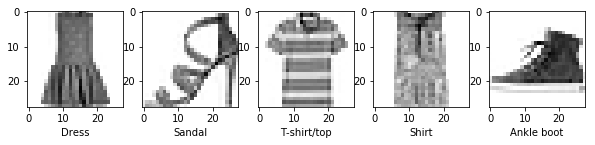

In [4]:
# Take some random examples, reshape to a 28x28 image and plot
from random import randint, seed
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,70000)
    axes[i].imshow(X[n].reshape(28, 28), cmap=plt.cm.gray_r)
    axes[i].set_xlabel((fmnist_classes[y[n]]))
plt.show();

In [5]:
# Extra imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
RANDOM_SEED=1337; np.random.seed(RANDOM_SEED)

## Evaluate k-Nearest Neighbors, Logistic Regression and Linear SVM. (1 point)
- Take a *stratified* 10% subsample of the data. Use it for everything below
- Evaluate the 3 classifiers with their default settings. Use cross-validation with 3 folds, output the accuracy and standard deviation.
- Discuss which one works best.

In [6]:
X_rest, X_sample, y_rest, y_sample = train_test_split(X, y, test_size=.1, random_state=RANDOM_SEED, stratify=y)
models = {'knn':KNeighborsClassifier(), 'logreg':LogisticRegression(), 'linSVC': LinearSVC()}
result = {}
for model_name in models:
    result[model_name] = cross_val_score(models[model_name], X_sample, y_sample, cv=3)
    
result_df = pd.DataFrame.from_dict(result, orient='index')
result_df['mean'] = result_df.apply(lambda row: np.mean([row[0], row[1], row[2]]), axis=1)
result_df['std'] = result_df.apply(lambda row: np.std([row[0], row[1], row[2]]), axis=1)
result_df

,0,1,2,mean,std
knn,0.82,0.79,0.79,0.80,1.57e-02
logreg,0.74,0.72,0.73,0.73,7.30e-03
linSVC,0.76,0.75,0.76,0.76,1.84e-03


Using default parameters, KNN performs better compared to logistic regression and linear SVC. Logistic regression has the worst accuracy among the three algorithms.

## Tune the parameters using GridSearchCV
- Vary the main hyperparameter (C or k) for all 3 models. Do the results improve?  Which ranges have an effect on performance?
- Visualize both the test score and training score as function of the parameters for all three models. Discuss when (for which values) the model is underfitting or overfitting.

In [7]:
models = {'knn':KNeighborsClassifier(), 'logreg':LogisticRegression(), 'linSVC': LinearSVC()}
GRID_PARAMS = {
    'knn': {'n_neighbors' : [2, 3, 4, 5, 6]},
    'logreg': {'C' : [3e-8, 3e-7, 3e-6, 3e-5, 3e-4]},
    'linSVC': {'C' : [3e-9, 3e-8, 3e-7, 3e-6, 3e-5]}
}
clf = {}
for model_name in models:
    clf[model_name] = GridSearchCV(models[model_name], GRID_PARAMS[model_name], cv=3, n_jobs=-1, return_train_score=True)
    clf[model_name].fit(X_sample, y_sample)

In [8]:
models_tuned = {
    'knn':KNeighborsClassifier(n_neighbors=clf['knn'].best_params_['n_neighbors']), 
    'logreg':LogisticRegression(C=clf['logreg'].best_params_['C']), 
    'linSVC': LinearSVC(C=clf['linSVC'].best_params_['C'])
}

result_tuned = {}
for model_name in models_tuned:
    result_tuned[model_name] = cross_val_score(models_tuned[model_name], X_sample, y_sample, cv=3)

In [9]:
result_tuned_df = pd.DataFrame.from_dict(result_tuned, orient='index')
result_tuned_df['mean'] = result_tuned_df.apply(lambda row: np.mean([row[0], row[1], row[2]]), axis=1)
result_tuned_df['std'] = result_tuned_df.apply(lambda row: np.std([row[0], row[1], row[2]]), axis=1)

In [10]:
result_tuned_df

,0,1,2,mean,std
knn,0.83,0.79,0.80,0.80,1.62e-02
logreg,0.82,0.82,0.83,0.83,4.98e-03
linSVC,0.82,0.82,0.83,0.82,5.52e-03


By using grid search to find the optimal parameters, all models' accuracy is improved. For KNN, the optimal `k` is 4, which is near to its default value (`k=5`), and the accuracy does not change significantly. On the other hand, performance of both logistic regression and linear SVM improved drastically if we set `C` as really small. 

For logistic regression, setting `C` withing range `[3e-07, 3e-05]` has effect on boosting performance, and the optimal `C=3e-06`. For linear SVM, the best value for `C` is `3e-07`, while setting `C` in the range of `[3e-08, 3e-06]` also works reasonably.

In [11]:
# You can use this generic plot for 1D grid search
# grid_search: the result of the GridSearchCV
# param_name: the name of the parameter that is being varied
def plot_tuning(grid_search, param_name):
    plt.figure()
    plt.plot(grid_search.param_grid[param_name], grid_search.cv_results_['mean_test_score'], marker = '.', label = 'Test score')
    plt.plot(grid_search.param_grid[param_name], grid_search.cv_results_['mean_train_score'], marker = '.', label = 'Train score')
    ax = plt.gca()
    ax.set_ylabel('score (ACC)')
    ax.set_xlabel(param_name)
    ax.legend()
    plt.title(grid_search.best_estimator_.__class__.__name__)
    print('Best configuration:' + str(grid_search.best_params_))
    print('Best score (ACC):' + str(grid_search.best_score_))

Best configuration:{'n_neighbors': 4}
Best score (ACC):0.804


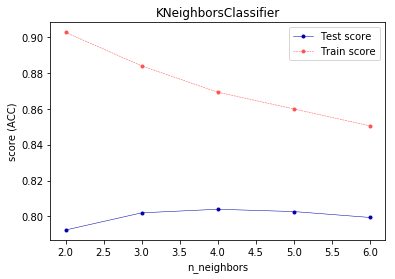

In [12]:
plot_tuning(clf['knn'], 'n_neighbors')

When `k=2`, the model tends to overfit with high training score and relatively lower test score compared to other value of `k`. As `k` getting bigger, we see that the train score keeps getting worse, but the test accuracy is more of the same. Therefore, the model is not overfitting and underfitting when `k` is in range of `[3,12]`, with the optimal `k=4`.

Best configuration:{'C': 3e-06}
Best score (ACC):0.8255714285714286


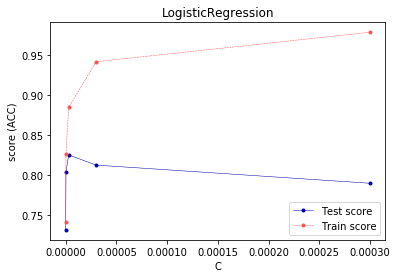

In [13]:
plot_tuning(clf['logreg'], 'C')

For logistic regression, the model tends to underfit when `C<3e-06`, whereas when `C>3e-06` it starts to overfit.

Best configuration:{'C': 3e-07}
Best score (ACC):0.8248571428571428


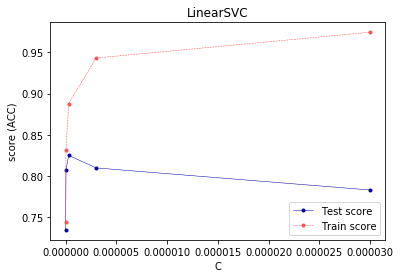

In [14]:
plot_tuning(clf['linSVC'], 'C')

For linear SVM, the model tends to underfit when `C<3e-07`, whereas when `C>3e-07` it starts to overfit.

## Analyze which types of misclassifications are made (1 points)
- Create a standard train_test split
- Train Logistic Regression on the training data and generate predictions on the test set
- Visualize (like above) a few examples that are misclassified by Logistic Regression. Discuss: are these indeed difficult cases?
- Build the 'confusion_matrix' of all predictions. Discuss which classes are often confused.

In [15]:
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X_sample, y_sample, random_state=RANDOM_SEED)

In [16]:
lr_model = LogisticRegression(C=clf['logreg'].best_params_['C'], random_state=RANDOM_SEED) # use optimal C from GridSearch
lr_model.fit(X_sample_train, y_sample_train)
y_pred = lr_model.predict(X_sample_test)

In [17]:
incorrect_pred = y_pred != y_sample_test
X_incorrects = X_sample_test[incorrect_pred]
y_incorrects = list(zip(y_pred[incorrect_pred], y_sample_test[incorrect_pred]))

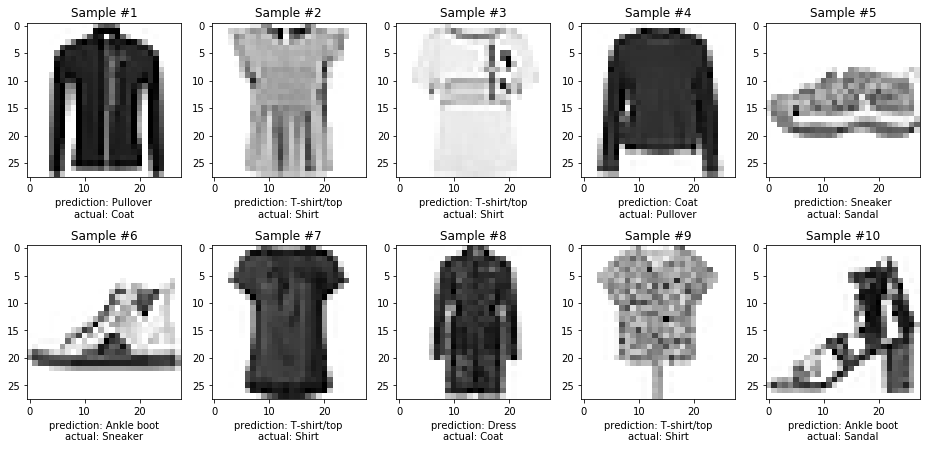

In [18]:
fig, axes = plt.subplots(2, 5, figsize=(16,7.5))
n = 0; randoms = []; seed(RANDOM_SEED)
for i in range(2*5):
    while n in randoms:
        n = randint(0,len(y_incorrects))
    randoms.append(n)
    axes[i//5][i%5].imshow(X_incorrects[n].reshape(28, 28), cmap=plt.cm.gray_r)
    axes[i//5][i%5].set_xlabel("prediction: {}\nactual: {}".format(fmnist_classes[y_incorrects[n][0]], fmnist_classes[y_incorrects[n][1]]))
    axes[i//5][i%5].set_title("Sample #{}".format(i+1))

Looking at the samples, those are indeed difficult cases even for humans. For example, `Sample #1` and `Sample #4` are hardly distinguishable, but they are from different classes. `Sample #3`, `#7`, and `#9` look like T-shirts instead of Shirt. `Sample #8` can be both Dress or Coat. Lastly, `Sample #5` looks more like a sneaker than a sandal.

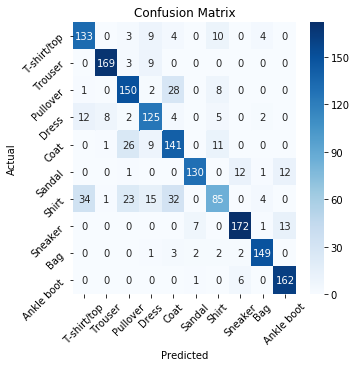

In [19]:
cm=confusion_matrix(y_sample_test, y_pred, labels=list(fmnist_classes.keys()))
fig, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
_=ax.xaxis.set_ticklabels(list(fmnist_classes.values()), rotation=45)
_=ax.yaxis.set_ticklabels(list(fmnist_classes.values()), rotation=45)

"Shirt" class is the most difficult class to predict, often misclassified as "T-shirt", "Coat", or "Pullover". "Pullover" and "Coat" classes also has misclassification between each other. There is also a slight confusion between footwear such as "Sandal", "Sneaker", and "Ankle boot". 

## Visualize the model parameters (1 point)
- Retrieve the model parameters (coefficients) for LogisticRegression and Linear Support Vector Machines
- Plot the coefficients as a 28*28 image as above. 
- Interpret the results. Which pixels does the models pay most attention to? Why? Is there a difference between both models?

In [20]:
ls_model = LinearSVC(C=clf['linSVC'].best_params_['C'], random_state=RANDOM_SEED)
ls_model.fit(X_sample_train, y_sample_train);

lr_coef = lr_model.coef_ # use the model retrieved from previous question
ls_coef = ls_model.coef_

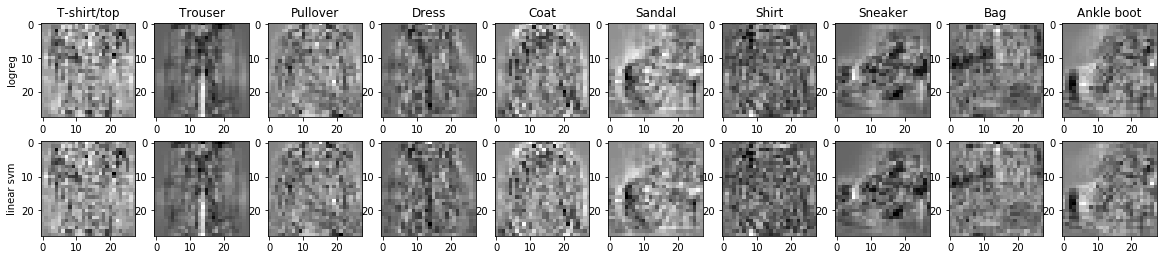

In [21]:
fig, axes = plt.subplots(2, 10, figsize=(20,4))

for i in range(len(fmnist_classes)):
    axes[0][i].imshow(lr_coef[i].reshape(28, 28), cmap=plt.cm.gray_r)
    axes[0][i].set_title(fmnist_classes[i])
    axes[1][i].imshow(ls_coef[i].reshape(28, 28), cmap=plt.cm.gray_r)
    
axes[0][0].set_ylabel('logreg')
axes[1][0].set_ylabel('linear svm')
plt.show()

By plotting the coefficient as 28x28 image, we can see extreme light-coloured pixels, which show relatively higher coefficients, and extreme dark-coloured pixels, which show relatively lower coefficients. Those are the pixels that the models pay most attention to.

Both logistic regression and linear SVC models pay most attention to the pixels of the outline of the object; it is especially clear for classes like "Trouser", "Sandal", and "Sneaker". For other classes such as "Shirt", "Pullover", and "Coat", we can also see that they put attention to the outline of the object, but it also has light- and dark-coloured pixels in other locations. This can happened due to more variation of the shape and motif, and could explain why the model's accuracy is worse on those classes. 

The models pay more attention to the outline of the object because outline is the best differentiator of either an image belong to a class or not. Similar to human, when we are looking at a grayscaled image of an object, we can classify it by looking at the shape.

Based on comparison between the coefficients images, there is no significant difference between logistic regression and linear SVM in terms of which pixels each pay more attention to.